### 1. Load exemplary waveforms

In [1]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

waveform_path = "./Waveforms"
files = os.listdir(waveform_path)

selected_idx = 0
print(f"The file to check is: {files[selected_idx]}")
all_results = np.loadtxt(f"{waveform_path}/{files[selected_idx]}",
                        skiprows=1, delimiter=",") # load all data

iL_PA_RNN, vp_ES, vs_ES = [all_results[:, i] 
                           for i in range(all_results.shape[1])] # assign each column into a var

The file to check is: 140V.csv


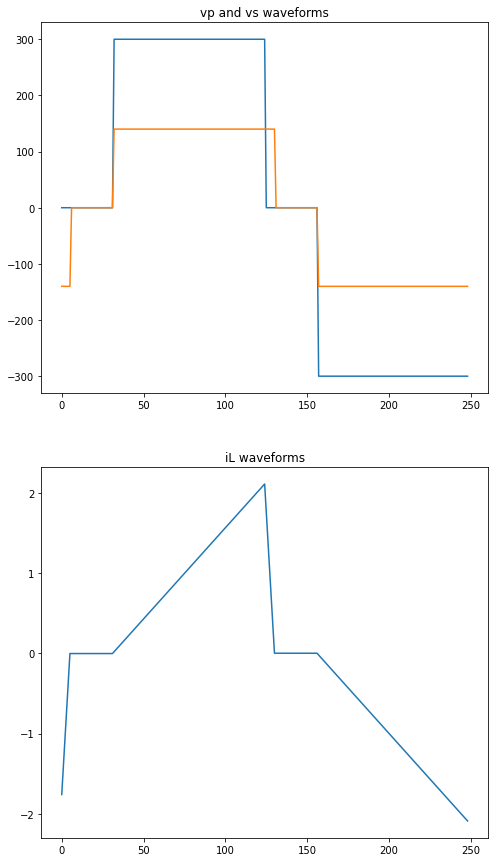

In [2]:
# Visualize the waveforms in three diverse scenarios
fig, axs = plt.subplots(2, 1, figsize=(8, 15))

for i, (waves, title) in enumerate(zip([(vp_ES, vs_ES), (iL_PA_RNN,)],
                                       ["vp and vs waveforms", "iL waveforms"])):
    for wave in waves:
        axs[i].plot(wave)
    axs[i].set_title(title)
plt.show()

### 2. Performance Metric 1 - Current Stress
* Peak-to-peak current stress: ipp
* Root-mean-square current stress: irms

In [3]:
def current_stress(iL, metric="ipp", delta_T=200e-9):
    assert metric in ["ipp", "irms"]
    if metric == "ipp":
        return max(iL)-min(iL)
    elif metric == "irms":
        return np.sqrt((iL**2).mean())

In [4]:
# get peak-to-peak current stress
ipp_PA_RNN = current_stress(iL_PA_RNN, metric="ipp")
print(f"ipp of PA-RNN is {ipp_PA_RNN:.2f} A.")

print("\n")

# get root-mean-square current stress
irms_PA_RNN = current_stress(iL_PA_RNN, metric="irms")
print(f"irms of PA-RNN is {irms_PA_RNN:.2f} A.")

ipp of PA-RNN is 4.20 A.


irms of PA-RNN is 1.08 A.


### 3. Performance Metric 2 - Soft Switching Performance
* Zero voltage switching: ZVS
* Zero current switching: ZCS

In [5]:
def locate(v, V):
    """
        Locate ip1, ip2, ip3, ip4
        and is1, is2, is3, is4
    """
    idx = [None]*4
    v0 = v[0]
    for i in range(1, len(v)+1):
        i = i % len(v)
        dV = v[i]-v0
        if (dV > V/2):
            if v0 < -V/2: idx[0] = i
            else: idx[1] = i
            if (dV > V*1.5):
                idx[1] = i
        elif (dV < -V/2):
            if v0 > V/2: idx[2] = i
            else: idx[3] = i
            if (dV < -V*1.5):
                idx[3] = i
        v0 = v[i]
    return idx

Vo_map = {0: 140, 1: 160}
def segment(vp, iL):
    V = Vo_map[selected_idx]
    # segment the NPC bridge to obtain each drain/collection current
    s_pri = np.array(vp>V/2).astype(np.float32)
    s_pri2 = np.array(vp>-V/2).astype(np.float32)
    iL = np.array(iL).astype(np.float32)
    iS1 = s_pri*iL
    iS4 = -(1-s_pri2)*iL
    iS2 = np.clip(s_pri+np.clip(s_pri2-s_pri, 0., 1.)*(iL>=0.), 0., 1.)*iL
    iS3 = -np.clip((1-s_pri2)+np.clip(s_pri2-s_pri, 0., 1.)*(iL<=0.), 0., 1.)*iL
    return iS1, iS2, iS3, iS4

In [6]:
def soft_switching(iL, vp, vs):
    iS1, iS2, iS3, iS4 = segment(vp, iL)
    indices = locate(vp, Vin)
    indices2 = locate(vs, Vo_map[selected_idx])
    ZVS = np.zeros(12, )
    ZCS = np.zeros(12, )
    
    
    ##### ZVS
    ZVS[0] = (iS1[indices[1]]<=1e-1).astype(int) # ZVS: S1
    ZVS[7] = (iS1[indices[1]]<=1e-1).astype(int) # ZVS: S8
    ZVS[1] = (iS2[indices[0]]<=1e-1).astype(int) # ZVS: S2
    ZVS[6] = (iS2[indices[0]]<=1e-1).astype(int) # ZVS: S7
    ZVS[2] = (iS3[indices[2]]<=1e-1).astype(int) # ZVS: S3
    ZVS[5] = (iS3[indices[2]]<=1e-1).astype(int) # ZVS: S6
    ZVS[3] = (iS4[indices[3]]<=1e-1).astype(int) # ZVS: S4
    ZVS[4] = (iS4[indices[3]]<=1e-1).astype(int) # ZVS: S5
    ZVS[8] = (iL[indices2[0]]>=-1e-1).astype(int) # ZVS: Q1
    ZVS[9] = (iL[indices2[2]]<=1e-1).astype(int) # ZVS: Q2
    ZVS[10] = (iL[indices2[3]]<=1e-1).astype(int) # ZVS: Q3
    ZVS[11] = (iL[indices2[1]]>=-1e-1).astype(int) # ZVS: Q4

    #### ZCS
    ZCS[0] = (np.abs(iS1[indices[2]])<=threshold).astype(int) # ZCS: S1
    ZCS[7] = (np.abs(iS1[indices[2]])<=threshold).astype(int) # ZCS: S8
    ZCS[1] = (np.abs(iS2[indices[3]])<=threshold).astype(int) # ZCS: S2
    ZCS[6] = (np.abs(iS2[indices[3]])<=threshold).astype(int) # ZCS: S7
    ZCS[2] = (np.abs(iS3[indices[1]])<=threshold).astype(int) # ZCS: S3
    ZCS[5] = (np.abs(iS3[indices[1]])<=threshold).astype(int) # ZCS: S6
    ZCS[3] = (np.abs(iS4[indices[0]])<=threshold).astype(int) # ZCS: S4
    ZCS[4] = (np.abs(iS4[indices[0]])<=threshold).astype(int) # ZCS: S5
    ZCS[8] = (np.abs(iL[indices2[2]])<=threshold).astype(int) # ZCS: Q1
    ZCS[9] = (np.abs(iL[indices2[0]])<=threshold).astype(int) # ZCS: Q2
    ZCS[10] = (np.abs(iL[indices2[1]])<=threshold).astype(int) # ZCS: Q3
    ZCS[11] = (np.abs(iL[indices2[3]])<=threshold).astype(int) # ZCS: Q4
    return ZVS, ZCS, indices, indices2

ZVS and ZCS performance of experimental data:
(array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.]))


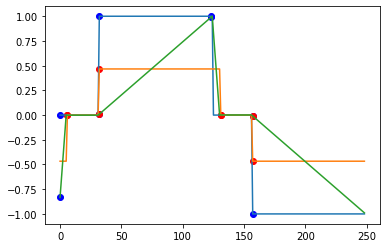

In [7]:
Vin = 300
threshold = 2e-2


ZVZCS_pred = soft_switching(iL_PA_RNN, vp_ES, vs_ES)
print("ZVS and ZCS performance of experimental data:")
print(ZVZCS_pred[:2])

indices, indices2 = ZVZCS_pred[2:]
indices[2] -= 1
indices[2] -= 1
plt.figure()
plt.plot(vp_ES/300)
plt.plot(vs_ES/300)
plt.scatter(indices, vp_ES[indices]/300, c="b")
plt.scatter(indices, iL_PA_RNN[indices]/iL_PA_RNN.max(), c="b")
plt.scatter(indices2, vs_ES[indices2]/300, c="r")
plt.scatter(indices2, iL_PA_RNN[indices2]/iL_PA_RNN.max(), c="r")
plt.plot(iL_PA_RNN/iL_PA_RNN.max())
plt.show()

### 4. Performance Metric 3 - Power
* Transferred power: PL
* Reactive power: Q

In [8]:
def power(vp, vs, iL, metric="PL", delta_T=200e-9):
    assert metric in ["PL", "Q"]
    if metric == "PL":
        return (vp*iL).mean()
    elif metric == "Q":
        vL = vp-n*vs
        return np.sqrt((vL**2).mean())*np.sqrt((iL**2).mean())

In [9]:
# get power transferred
PL_PA_RNN = power(vp_ES, vs_ES, iL_PA_RNN, metric="PL")
print(f"PL of PA-RNN is {PL_PA_RNN:.2f} W.")

print("\n")

# get reactive power
n = 2
Q_PA_RNN = power(vp_ES, vs_ES, iL_PA_RNN, metric="Q")
print(f"Q of PA-RNN is {Q_PA_RNN:.2f} W.")

PL of PA-RNN is 236.21 W.


Q of PA-RNN is 68.83 W.
